# Лабораторная работа №2: Реализация продвинутых ансамблевых методов

**Цель работы:**
Реализовать современные ансамблевые алгоритмы машинного обучения и исследовать их эффективность.

## Задачи
1. Реализовать Gradient Boosting с нуля:
   - Градиентный спуск по функциональному пространству
   - Функции потерь: MSE, MAE, Logistic loss
   - Регуляризация: learning rate, subsampling
2. Реализовать упрощённую версию XGBoost:
   - Второй порядок градиентов (Hessian)
   - Регуляризация L1/L2 для листьев
   - Обработка разреженных данных
3. Реализовать Stacking:
   - Базовые алгоритмы разных типов
   - Мета-алгоритм с cross-validation
4. Реализовать Voting классификатор:
   - Hard voting, soft voting
   - Взвешенное голосование
5. Исследовать влияние гиперпараметров:
   - Количество деревьев
   - Глубина деревьев
   - Learning rate
   - Доля выборки (subsample)
6. Провести bias-variance decomposition анализ.
7. Сравнить с реализацией scikit-learn на наборах: Adult, Titanic, Bank Marketing.
8. Проанализировать feature importance и интерпретируемость.

## Источники данных
- Adult (классификация):
  ```
  import io

  import pandas as pd
  import requests

  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
  resp = requests.get(url, verify=False)
  col_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
  'hours-per-week', 'native-country', 'income'
  ]

  df = pd.read_csv(io.StringIO(resp.text), names=col_names, sep=',\s', engine='python')
  ```
- Titanic (классификация):
  ```
  import seaborn as sns
  df = sns.load_dataset('titanic')
  ```
- Bank Marketing (классификация):
  ```
  df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.csv', sep=';')
  ```

## Структура отчета
1. **Введение** — цели и описание алгоритмов.
2. **Теория** — математическое обоснование ансамблей.
3. **Реализация** — код (NumPy).
4. **Эксперименты** — исследование гиперпараметров.
5. **Сравнение** — scikit-learn vs ваша реализация.
6. **Интерпретируемость** — анализ feature importance.
7. **Выводы** — рекомендации.

## Критерии оценивания (15 баллов)
- Реализация Gradient Boosting и XGBoost — 6 баллов
- Реализация Stacking и Voting — 4 балла
- Эксперименты и подбор гиперпараметров — 3 балла
- Анализ feature importance и bias-variance — 1 балл
- Качество отчёта и визуализаций — 1 балл

## Отчет

### Введение

#### Цель работы

Реализовать современные ансамблевые алгоритмы машинного обучения и исследовать их эффективность.

#### Описание алгоритмов

Бустинг - обучение модели на ошибках предыдущих моделей.

Stacking - использование предсказаний базовых моделей для обучения мета-модели.

Voting - использование предсказаний базовых моделей для выбора итогового предсказания.

### Теория

#### Gradient Boosting

**Бустинг** - обучение модели на ошибках предыдущих моделей.

Минимизируем следующую функцию потерь:
$$\large
L(y,\hat{y})=\sum_{i=1}^nl(y_{i},\hat{y_{i}})
$$
Зададим нашу модель следующим образом:
$$\large
\hat{y_{i}}=F(x_{i})=f_{0}(x_{i})+f_{1}(x_{i})+\dots f_{T}(x_{i})
$$
Для минимизации заданной функции потерь можно использовать градиентные методы, а именно **функциональный градиентный спуск**.

##### Функциональный градиентный спуск

Текущее предсказание модели для каждого объекта $\large x_{i} - F_{t-1}(x_{i})$.
По аналогии с простым градиентным спуском, возьмем частную производную у функции потерь:
$$\large
g_{i}=\frac{\partial l(y_{i},F_{t-1}(x_{i}))}{\partial F_{t-1}(x_{i})}
$$
Но мы просто так не можем вычесть из функции $\large \alpha g_{i}$, где $\large \alpha\,-\,$learning rate, так как $\large F(x)\,-\,$функция.
Соответственно, нужно найти такую функцию $\large f_{t}(x_{i})$, чтобы:
$$\large
f_{y}(x_{i})\approx-g_{i}
$$
Т.е **новая модель должна предсказывать антиградиенты**.

##### Построение дерева

Вообще говоря, целью для дерева обычно ставят нахождение псевдоостатков $\large r_{i}=-g_{i}$.

Как получить эти псевдоостатки?

Дерево строится следующим образом:
1. Корень содержит все объекты
2. На каждом шаге выбираем один признак и порог
3. Объекты в соответствии с порогом распределяются в правого и в левого потомков
4. Повторяем это рекурсивно до какого-то критерия остановки

В итоге все объекты попадают в **листья** - конечные узлы, где больше не происходит разбиений.

Далее в каждом листе дерево должно выдать одно число - предсказание для всех объектов, попавших в этот лист. Дерево решений - кусочно-постоянная функция, поэтому оно не может выдать для каждого объекта, попавшего в лист, уникальные значения. Ну или может, если каждый лист будет состоять из одного объекта.

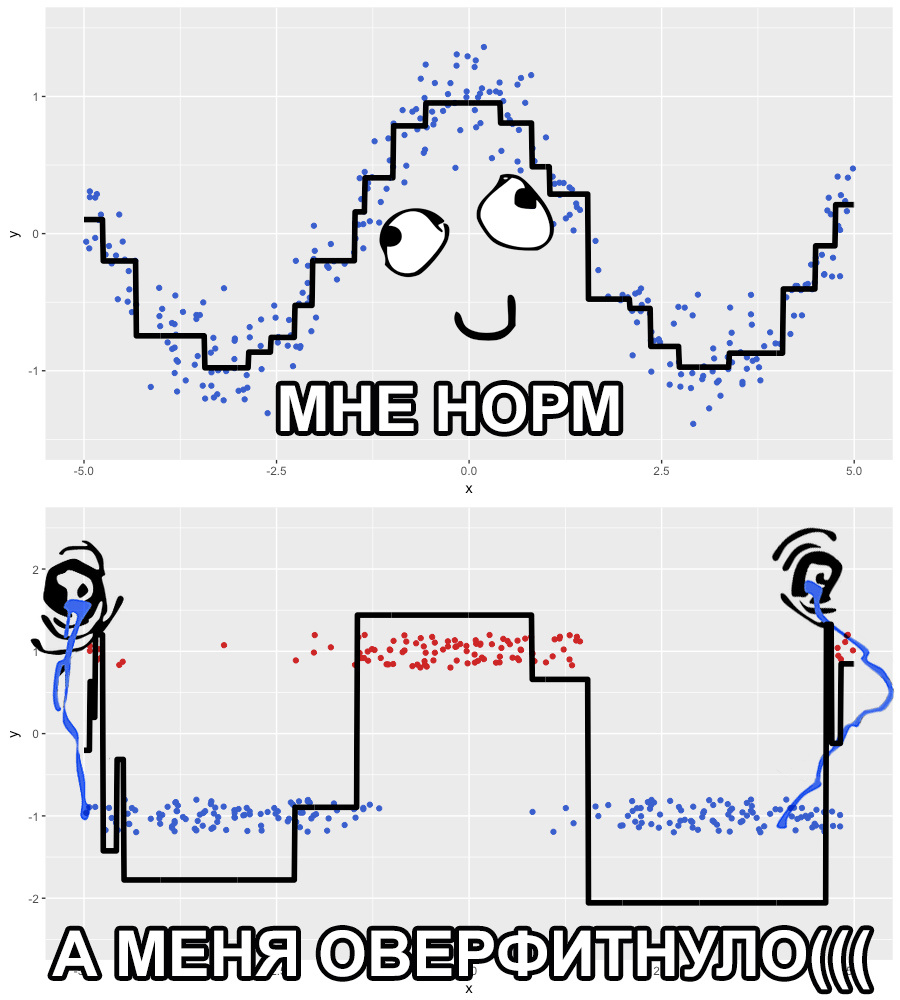

Ну и соответственно встает вопрос, как выбрать эти числа для каждого листа. Всё зависит от функции потерь, которую мы минимизируем внутри дерева.

##### MSE

Если наша цель - минимизировать
$$\large
\sum_{i\,\in\,лист}(f(x_{i})-r_{i})^2=\sum_{i\,\in\,лист}(\nu-r_{i})^2
$$
то оптимальное значение $\large \nu\,-\,$среднее арифметическое:
$$\large
\nu=\frac{1}{n_{лист}}\sum_{i\,\in\,лист}r_{i}
$$
Это выводится дифференцированием $\large L(\nu)$ по $\large \nu$.

##### MAE

Оптимальным значением $\large \nu$ в случае $\large L(\nu)=\sum|\nu-r_{i}|$ будет просто медиана значений $\large r_{i}$.
##### Как выбрать оптимальный порог разбиения?

Для каждого разбиения вычисляем **gain** - прирост качества.

Пусть в родительском узле P мы используем одно значение $\large \nu_{P}$ для всех объектов. Ошибка при использовании MSE тогда:
$$\large
Ошибка_{P}=\sum_{i\in P}(\nu_{P}-r_{i})^2
$$
Если разбить на L и R и использовать $\large \nu_{L},\nu_{R}$, то ошибка станет:
$$\large
Ошибка_{L+R}=\sum_{i\in L}(\nu_{L}-r_{i})^2+\sum_{i\in R}(\nu_{R}-r_{i})^2
$$
Тогда Gain будет:
$$\large
Gain=Ошибка_{P}-Ошибка_{L+R}
$$
Чем больше Gain, тем лучше разбиение.

##### Как посчитать gain?

Считать напрямую - медленно, так как нужно хранить все $\large r_{i}$ и вычислять суммы квадратов. Вместо этого можно воспользоваться аналитическим решением.

Вспомним:
$$\large
\nu=\frac{1}{n_{лист}}\sum_{i\,\in\,лист}r_{i},\,R_{лист}=\sum_{i\,\in\,лист}r_{i}
$$
Тогда минимальная ошибка в узле S:
$$\large
MSE_{S}=\sum_{i\in S}(r_{i}-\nu_{S})^2=\sum_{i\in S}r^2_{i}-\frac{R^2_{S}}{|S|}
$$
Gain:
$$\large
Gain=\left( \sum_{i\in P}r^2_{i}-\frac{R^2_{P}}{|P|} \right)-\left( \sum_{i\in L}r_{i}^2-\frac{R^2_{L}}{|L|}+\sum_{i\in R}r^2_{i}-\frac{R^2_{R}}{|R|} \right)
$$
Т.к $\large \sum_{i\in P}r^2_{i}=\sum_{i\in L}r^2_{i}+\sum_{i\in R}r^2_{i}$, то остается:
$$\large
Gain=\frac{R^2_{L}}{|L|}+\frac{R^2_{R}}{|R|}-\frac{R^2_{P}}{|P|}
$$
$$\large
Gain=\frac{\left( \sum_{i\in L}g_{i} \right)^2}{|L|}+\frac{\left( \sum_{i\in R}g_{i} \right)^2}{|R|}-\frac{\left( \sum_{i\in P}g_{i} \right)^2}{|P|}
$$
##### Обучение градиентного бустинга

После построения дерева решений необходимо обучить градиентный бустинг.

Ещё раз зададим нашу модель:
$$\large
F_{T}(x)=f_{0}(x)+\alpha f_{1}(x)+\alpha f_{2}(x)+\dots+\alpha f_{T}(x)
$$
где:
$$\large
\begin{aligned} f_{0}(x)\,-\,начальное\,предсказание\,(обычно\,константа), \\ f_{t}(x)\,-\,дерево,\,построенное\,на\,шаге\,t, \\ \alpha\,-\,learning\,rate, \\ T\,-\,число\,итераций\,(деревьев) \end{aligned}
$$
##### Инициализация

Обычно в качестве начального предсказания $\large f_{0}(x)$ берут константу:
1. Для MSE - $\large \frac{1}{n}\sum y_{i}$
2. Для MAE - 
3. Для LogLoss - $\large \log\left( \frac{\bar{y}}{1-\bar{y}} \right)$, где $\large \bar{y}=\frac{1}{n}\sum y_{i}$
##### Вычисление градиентов

На каждой итерации вычисляем градиенты функции потерь:
$$\large
g_{i}=\frac{\partial l(y_{i},F_{t-1}(x_{i}))}{\partial F_{t-1}(x_{i})}
$$
Дерево должно двигать свои предсказания в направлении уменьшения потерь:
$$\large
f_{t}(x_{i})\approx -g_{i}
$$
Далее задаем псевдоостатки по формуле $\large r_{i}=-g_{i}$.

##### Обучение дерева и обновление предсказаний модели

Обучаем дерево выше, после обучения получаем функцию $\large f_{t}(x)$, которая аппроксимирует антиградиенты.
Далее обновляем предсказания:
$$\large
\bar{y_{t}}=\bar{y_{t-1}}+\alpha f_{t}(x)
$$
Повторяем это T раз.

#### XGBoost

Снова введем модель, с помощью которой будем решать задачу:
$$\large
F_{T}(x)=f_{0}+\sum_{t=1}^T\eta f_{t}(x)
$$
где $\large f_{t}(x)$ - дерево решений.

Гиперпараметры:
- $\large T\in N$ - число деревьев
- $\large \eta\in(0,1]$ - learning rate
- $\large \lambda\geq0$ - L2 регуляризация
- $\large \alpha\geq0$ - L1 регуляризация
- $\large \gamma\geq0$ - штраф за сложность дерева

После $\large t-1$ итераций у нас есть текущая модель $\large F_{t-1}(x)$.

**Ищем функцию $\large f_{t}(x)$, минимизирующую:**
$$\large
\mathcal{J}^{(t)}(f)=\sum_{i=1}^nl(y_{i},F_{t-1}(x_{i})+f(x_{i}))+\Omega(f)
$$
где регуляризатор:
$$\large
\Omega(f)=\gamma T_{f}+\frac{1}{2}\lambda \sum_{j=1}^{T_{f}}w_{j}^2+\alpha \sum_{j=1}^{T_{f}}|w_{j}|
$$
- $\large T_{f}\,-\,$число листьев в функции $\large f$
- $\large w_{j}\,-\,$ значение в j-м листе

Так как минимизировать функционал $\large \mathcal{J}$ напрямую невозможно, потому что $\large l$ - нелинейная функция, а $\large f$ - дерево (дискретная структура), разложим $\large l$ в ряд Тейлора до второго порядка вокруг $\large F_{t-1}(x_{i})$:
$$\large
l(y_{i},F_{t-1}(x_{i})+f(x_{i}))\approx l(y_{i},F_{t-1}(x_{i}))+g_{i}f(x_{i})+\frac{1}{2}h_{i}f(x_{i})^2
$$
где:
- $\large g_{i}=\frac{\partial l(y_{i},F)}{\partial F}|_{F=F_{t-1}(x)}$
- $\large h_{i}=\frac{\partial^2 l(y_{i},F)}{\partial F^2}|_{F=F_{t-1}(x)}$

Аппроксимируем $\large \mathcal{J}$:
$$\large
\tilde{\mathcal{J}}^{(t)}(f)=\sum_{i=1}^n\left[ g_{i}f(x_{i})+\frac{1}{2}h_{i}f(x_{i})^2 \right]+\Omega(f)
$$
Как было сказано ранее, $\large f(x)$ - дерево решений с T листьями:
$$\large
f(x)=\sum_{j=1}^Tw_{j}\cdot \mathbb{1}(x\in R_{j})
$$
где:
- $\large R_{j}$ - область (лист) j
- $\large w_{j}\in R$ - значение в листе
- $\large \mathbb{1}$ - индикатор

Обозначим:
$$\large
I_{j}={i:x_{i}\in R_{j}}\,-\,\text{множество объектов в листе j}
$$
Тогда:
$$\large
\tilde{\mathcal{J}}^{(t)}=\sum_{j=1}^T\left[ w_{j}\sum_{i\in I_{j}}g_{i}+\frac{1}{2}w^2_{j}\sum_{i\in I_{j}}h_{i} \right]+\gamma T+\frac{1}{2}\lambda \sum_{j=1}^Tw_{j}^2+\alpha \sum_{j=1}^T|w_{j}|
$$
Обозначим:
- $\large G_{j}=\sum_{i\in I_{j}}g_{i}$
- $\large H_{j}=\sum_{i\in I_{j}}h_{i}$

ТОгда функционал по листу j:
$$\large
\mathcal{L}_{j}(w_{j})=G_{j}w_{j}+\frac{1}{2}H_{j}w^2_{j}+\frac{1}{2}\lambda w_{j}^2+\alpha|w_{j}|+\gamma
$$
**Как найти оптимальное значение $\large w_{j}$?**

Минимизируем $\large \mathcal{L}_{j}$ по $\large w\in R$.

Функция:
$$\large
\mathcal{L}=Gw+\frac{1}{2}(H+\lambda)w^2+\alpha|w|
$$
Это выпуклая, но недифференцируемая в 0 функция.

**Рассмотрим 3 случая:**

$\large w>0$:

Тогда $\large |w|=w$ и производная:
$$\large
\frac{d\mathcal{L}}{dw}=G+(h+\lambda)w+\alpha=0\implies w=-\frac{G+\alpha}{H+\lambda}
$$
Это решение допустимо, если $\large w>0$:
$$\large
-\frac{G+\alpha}{H+\lambda}>0\implies G+\alpha<0\implies G<-\alpha
$$
Т.к $\large \lambda$ всегда больше 0, а $\large H$ - гессиан функции потерь по предсказанию, поэтому из-за выпуклости фукнции потерь, вторая производная (гессиан) неотрицателен.

$\large w<0$:

Тогда $\large |w|=-w$ и производная:
$$\large
\frac{d\mathcal{L}}{dw}=G+(h+\lambda)w-\alpha=0\implies w=-\frac{G-\alpha}{H+\lambda}
$$
Это решение допустимо, если $\large w<0$:
$$\large
-\frac{G-\alpha}{H+\lambda}>0\implies G-\alpha>0\implies G>\alpha
$$

$\large w=0$:

(На этом моменте стоит расписать, что такое субдифференциал, но примем как данность)

0 - минимум, если $\large 0\in \partial \mathcal{L}(0)$, т.е:
$$\large
G-\alpha\leq0\leq G+\alpha\implies|G|\leq \alpha
$$
Оптимальный вес:
$$\large
w^*=\begin{cases} -\frac{G+\alpha}{H+\lambda},\,\text{если}\,G<-\alpha \\ 0,\text{если}\,|G|\leq\alpha \\ -\frac{G-\alpha}{H+\lambda},\,\text{если}\,G>\alpha \end{cases}
$$
Что эквивалентно:
$$\large
w^*=\frac{-sign(G)\cdot max(|G|-\alpha,0)}{H+\lambda}
$$
**Минимальное значение функционала в листе**

Подставим $\large w^*$ в $\large \mathcal{L}_{j}(w)$.

Опустим вычисления и констатируем следующее - оба случая, $\large G<-\alpha$ и $\large G>\alpha$ дают один результат, их можно объединить в один случай - $\large |G|>\alpha$.

Если $\large |G|\leq \alpha$, то:
$$\large
\mathcal{L}^*_{j}=0+0+0+\gamma=\gamma
$$
Если $\large |G|>\alpha$, то:
$$\large
\mathcal{L}^*_{j}=-\frac{1}{2}\frac{(|G|-\alpha)^2}{H+\lambda}+\gamma
$$
**Далее при построении дерева нам необходимо рассчитывать Gain**

Пусть родительский узел P разбивается на L и R.
Без разбиения ошибка - $\large \mathcal{L^*}_{P}$
С разбиением ошибка - $\large \mathcal{L^*}_{L}+\mathcal{L^*}_{R}$
$$\large
Gain=\mathcal{L^*}_{P}-(\mathcal{L^*}_{L}+\mathcal{L^*}_{R})
$$
После подстановки всех значений, а также согласно оптимизации в оригинальном XGBoost (в оригинальном XGBoost gain вычисляется без учёта L1):
$$\large
Gain=\frac{1}{2}\left[ \frac{G^2_{L}}{H_{L}+\lambda}\,+\frac{G^2_{R}}{H_{R}+\lambda} -\frac{G^2_{P}}{H_{P}+\lambda}  \right]-\gamma
$$
а $\large w^*$ вычисляется по формуле с $\large \alpha$.

**Обработка разреженных данных**

Алгоритм следующий:
1. При сортировке значений признака:
	1. Пропущенные значения исключаются из сортировки
2. При переборе порогов:
	1. Для каждого порога вычисляются статистики только по непропущенным объектам
	2. Затем добавляются пропущенные - сначала все влево, потом все вправо
	3. Выбирается направление с максимальным gain
3. В итоговом дереве:
	1. В узле сохраняется дополнительное правило для пропущенных значений, в какую ветку их отсылать

#### Stacking

В основе Stacking лежит идея использования предсказаний нескольких моделей в качестве признаков для мета-модели, которая обучается на них и делает финальное предсказание.

Для предотвращения переобучения используется кросс-валидация:
1. Обучающая выборка делится на K фолдов
2. Для каждой базовой модели:
	1. Обучаем её на K-1 фолдах
	2. Делаем предсказания на оставшемся фолде
	3. Повторяем для  всех K фолдов
3. Собираем предсказания от всех моделей и получаем матрицу признаков для мета-модели
4. Обучаем мета-модель
5. На новых данных:
	1. Все базовые модели делают предсказания
	2. Мета-модель на основе этих предсказаний делает своё предсказание

Такой подход позволяет избавиться от переобучения мета-модели, так как каждая базовая модель делает предсказания на данных, которые не видела, что улучшает обобщающую способность мета-модели.

#### Voting

В основе Voting лежит голосование нескольких моделей, и в отличие от stacking, здесь нет мета-модели.
##### Hard-voting

При hard-voting итоговое предсказание формируется с помощью моды - наиболее часто встречающегося класса среди всех предсказаний базовых моделей. Такой подход не учитывает уверенность моделей в своих предсказаниях.

##### Soft-voting

При soft-voting итоговое предсказание формируется с помощью усредненной вероятности класса - у какого класса будет вероятность выше, тот и будет считаться итоговым предсказанием.

##### Взвешенное голосование

Взвешенное голосование может применяться и при hard-voting, и при soft-voting. При hard-voting каждый голос будет умножаться на вес модели, а при soft-voting вероятности усредняются с весами.

## Реализация

In [13]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import random

In [10]:
class Loss:        
    def base_predictions(self, y):
        raise NotImplementedError

    def gradients(self, F_i, y_i):
        raise NotImplementedError

    def hessians(self, F_i, y_i):
        raise NotImplementedError

class MSELoss(Loss):
    def base_predictions(self, y):
        return np.mean(y)

    def gradients(self, F_i, y_i) -> float:
        return F_i - y_i
    
    def hessians(self, F_i, y_i):
        return np.ones_like(F_i)
    
class MAELoss(Loss):
    def base_predictions(self, y):
        return np.mean(y)

    def gradients(self, F_i, y_i):
        return F_i - y_i
    
    def hessians(self, F_i, y_i):
        return np.ones_like(F_i)
    
class LogisticLoss(Loss):
    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))
    
    def base_predictions(self, y):
        pos_ratio = np.mean(y)
        pos_ratio = np.clip(pos_ratio, 1e-15, 1 - 1e-15)
        return np.log(pos_ratio / (1 - pos_ratio))
    
    def gradients(self, F_i, y_i):
        p = self._sigmoid(F_i)
        return p - y_i
    
    def hessians(self, F_i, y_i):
        p = self._sigmoid(F_i)
        return p * (1 - p)


In [9]:
class Node:
    def __init__(self, is_leaf, value, feature, threshold, left: None, right: None):
        self.is_leaf = is_leaf
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

    def predict(self, X):
        if self.is_leaf:
            return self.value
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)

class XGBoostNode:
    def __init__(self, is_leaf, value, feature, threshold, missing_value, default_left, left: None, right: None):
        self.is_leaf = is_leaf
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.missing_value = missing_value
        self.default_left = default_left

    def predict(self, X):
        if self.is_leaf:
            return self.value
        val = X[self.feature]
        is_missing = (
            (self.missing_value is np.nan and np.isnan(val)) or
            (val == self.missing_value)
        )
        if is_missing:
            child = self.left if self.default_left else self.right
        else:
            child = self.left if val < self.threshold else self.right
        return child.predict(X)
            


class Tree:
    def __init__(self, max_depth, min_samples_leaf, min_gain_to_split):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain_to_split = min_gain_to_split

    def _build_node(self, X, r, S, depth, n_features):
        n_S = len(S)
        if n_S < 2 * self.min_samples_leaf or depth >= self.max_depth:
            nu = np.mean(r[S]) if n_S > 0 else 0
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        best_gain = - np.inf
        best_feature = None
        best_threshold = None
        best_L = None
        best_R = None
        for j in range(n_features):
            pairs = [(X[i][j], r[i], i) for i in S]
            pairs.sort()
            sum_left = 0
            count_left = 0
            sum_right = np.sum(r[S])
            count_right = n_S

            for k in range(n_S - 1):
                (_, r_val, idx) = pairs[k]
                sum_left += r_val
                count_left += 1
                sum_right -= r_val
                count_right -= 1

                if count_left < self.min_samples_leaf or count_right < self.min_samples_leaf:
                    continue

                total_sum = sum_left + sum_right
                gain = (sum_left**2 / count_left) + (sum_right**2 / count_right) - (total_sum**2 / n_S)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = j
                    next_val = pairs[k+1][0]
                    best_threshold = (pairs[k][0] + next_val) / 2
                    
                    best_L = [i[2] for i in pairs[0:k+1]]
                    best_R = [i[2] for i in pairs[k+1:]]

        if best_gain < self.min_gain_to_split:
            nu = (1 / n_S) * sum(r)
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        left_child = self._build_node(X, r, best_L, depth+1, n_features)
        right_child = self._build_node(X, r, best_R, depth+1, n_features)

        return Node(
            value=None,
            is_leaf=False,
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )

    def fit(self, X, r):
        n = X.shape[0]
        d = X.shape[1]
        root_idx = np.arange(0, n)
        self.root = self._build_node(X=X, r=r, S=root_idx, depth=0, n_features=d)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return np.array(predictions, dtype=float)
        

class XGBoostTree:
    def __init__(self, reg_lambda, reg_alpha, gamma, missing_value, max_depth, min_child_weight):
        self.root = None
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.gamma = gamma
        self.missing_value = missing_value
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight

    def _compute_weight(self, G, H):
        if H + self.reg_lambda == 0:
            return 0.0
        if G > self.reg_alpha:
            return - (G - self.reg_alpha) / (H + self.reg_lambda)
        elif G < -self.reg_alpha:
            return - (G + self.reg_alpha) / (H + self.reg_lambda)
        else:
            return 0

    def _build_node(self, X, g, h, S, depth, n_features, missing_value):
        G = np.sum(g[S])
        H = np.sum(h[S])
        n_S = len(S)

        if depth >= self.max_depth:
            w = self._compute_weight(G, H)
            return XGBoostNode(is_leaf=True, value=w, feature=None, 
                        threshold=None, left=None, right=None, missing_value=None, default_left=None)

        best_gain = - np.inf
        best_feature = None
        best_threshold = None
        best_default_left = None
        best_L = None
        best_R = None
        for j in range(n_features):
            known = []
            missing = []
            for i in S:
                if X[i][j] == missing_value or np.isnan(X[i][j]):
                    missing.append((g[i], h[i], i))
                else:
                    known.append((X[i][j], g[i], h[i], i))
            known.sort(key=lambda x: x[0])
            # pairs = [(X[i][j], g[i], h[i], i) for i in S]
            # pairs.sort()
            G_known = sum(item[1] for item in known)
            H_known = sum(item[2] for item in known)
            G_L = 0
            H_L = 0
            G_R = G_known
            H_R = H_known
            n_known = len(known)
            for k in range(n_known - 1):
                (x_val, g_val, h_val, idx) = known[k]
                G_L += g_val
                H_L += h_val
                G_R -= g_val
                H_R -= h_val

                if x_val == known[k + 1][0]:
                    continue

                G_miss = sum(item[0] for item in missing)
                H_miss = sum(item[1] for item in missing)

                G_L1 = G_L + G_miss
                H_L1 = H_L + H_miss
                G_R1 = G_R
                H_R1 = H_R

                if H_L1 >= self.min_child_weight and H_R1 >= self.min_child_weight:
                    gain1 = 0.5 * (
                        G_L1 * G_L1 / (H_L1 + self.reg_lambda) +
                        G_R1 * G_R1 / (H_R1 + self.reg_lambda) -
                        G * G / (H + self.reg_lambda)
                    ) - self.gamma
                else:
                    gain1 = - np.inf
                
                G_L2 = G_L
                H_L2 = H_L
                G_R2 = G_R + G_miss
                H_R2 = H_R + H_miss

                if H_L2 >= self.min_child_weight and H_R2 >= self.min_child_weight:
                    gain2 = 0.5 * (
                        G_L2 * G_L2 / (H_L2 + self.reg_lambda) +
                        G_R2 * G_R2 / (H_R2 + self.reg_lambda) -
                        G * G / (H + self.reg_lambda)
                    ) - self.gamma
                else:
                    gain2 = - np.inf

                if gain1 > gain2:
                    current_gain = gain1
                    default_left = True
                else:
                    current_gain = gain2
                    default_left = False

                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature = j
                    next_val = known[k+1][0]
                    best_threshold = (known[k][0] + next_val) / 2
                    best_default_left = default_left

                    known_L = [i[3] for i in known[0:k+1]]
                    known_R = [i[3] for i in known[k+1:]]
                    
                    if default_left:
                        best_L = known_L + [i[2] for i in missing]
                        best_R = known_R
                    else:
                        best_L = known_L
                        best_R = known_R + [i[2] for i in missing]                       

        if best_gain <= 0 or best_feature is None:
            w = self._compute_weight(G, H)
            return XGBoostNode(is_leaf=True, value=w, feature=None, 
                        threshold=None, left=None, right=None, missing_value=None, default_left=None)
        

        left_child = self._build_node(X, g, h, best_L, depth+1, n_features, missing_value)
        right_child = self._build_node(X, g, h, best_R, depth+1, n_features, missing_value)

        return XGBoostNode(
            value=None,
            is_leaf=False,
            feature=best_feature,
            threshold=best_threshold,
            missing_value=missing_value,
            default_left=best_default_left,
            left=left_child,
            right=right_child
        )

    def fit(self, X, g, h):
        n = X.shape[0]
        d = X.shape[1]
        root_idx = np.arange(0, n)
        self.root = self._build_node(X, g, h, root_idx, depth=0, n_features=d, missing_value=self.missing_value)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return np.array(predictions, dtype=float)


### GradientBoosting

In [11]:
class MyGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, loss=None, learning_rate=0.1, n_estimators=100, subsampling=1.0, max_depth=3, min_samples_leaf=1, min_gain_to_split=0.0):
        self.loss = loss
        self.learning_rate = learning_rate
        self.base_prediction = None
        self.trees = []
        self.n_estimators = n_estimators
        self.subsampling = subsampling
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain_to_split = min_gain_to_split

    def _random_subset(self, n):
        size = int(self.subsampling * n)
        sample = np.random.choice(n, size, replace=False)
        return sample

    def fit(self, X, y):
        n = X.shape[0]
        self.base_prediction = self.loss.base_predictions(y)
        F = np.full(shape=n, fill_value=self.base_prediction)

        for t in range(self.n_estimators):
            subset_idx = self._random_subset(n)
            residuals = np.zeros(n, dtype=float)
            for i in subset_idx:
                residuals[i] = -self.loss.gradients(F[i], y[i])

            tree = Tree(
                max_depth = self.max_depth,
                min_samples_leaf = self.min_samples_leaf,
                min_gain_to_split = self.min_gain_to_split
            )
            tree.fit(X[subset_idx], residuals[subset_idx])

            tree_preds = tree.predict(X)
            F = F + self.learning_rate * tree_preds

            self.trees.append(tree)
        
        return self

    def predict_raw(self, X):
        n = X.shape[0]
        predictions = np.full(shape=n, fill_value=self.base_prediction)
        for tree in self.trees:
            tree_predict = tree.predict(X)
            predictions = predictions + self.learning_rate * tree_predict
        
        return predictions

    def predict_proba(self, X):
        pred = self.predict_raw(X)
        n_samples = pred.shape[0]
        n_classes = 2
        proba = np.zeros((n_samples, n_classes))
        proba[:, 1] = 1 / (1 + np.exp(-pred))
        proba[:, 0] = 1 - proba[:, 1]
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred, sample_weight=sample_weight)



### XGBoost

In [12]:
class MyXGBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, loss=None, learning_rate=0.1, n_estimators=100, subsampling=1.0, 
                 missing_value=None, gamma=0.0, reg_lambda=1.0, reg_alpha=0.0, 
                 max_depth=3, min_child_weight=1):
        self.loss = loss
        self.learning_rate = learning_rate
        self.base_prediction = None
        self.trees = []
        self.n_estimators = n_estimators
        self.subsampling = subsampling
        self.missing_value = missing_value
        self.gamma = gamma
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight

    def _random_subset(self, n):
        size = int(self.subsampling * n)
        sample = np.random.choice(n, size, replace=False)
        return sample

    def fit(self, X, y):        
        n = X.shape[0]
        self.base_prediction = self.loss.base_predictions(y)
        F = np.full(shape=n, fill_value=self.base_prediction)

        for t in range(self.n_estimators):
            subset_idx = self._random_subset(n)
            g = np.zeros(n, dtype=float)
            h = np.zeros(n, dtype=float)
            for i in subset_idx:
                g[i] = self.loss.gradients(F[i], y[i])
                h[i] = self.loss.hessians(F[i], y[i])

            tree = XGBoostTree(
                missing_value = self.missing_value,
                gamma = self.gamma,
                reg_lambda = self.reg_lambda,
                reg_alpha = self.reg_alpha,
                max_depth = self.max_depth,
                min_child_weight = self.min_child_weight,
            )
            tree.fit(X[subset_idx], g[subset_idx], h[subset_idx])

            tree_preds = tree.predict(X)
            F = F + self.learning_rate * tree_preds

            self.trees.append(tree)
        
        return self

    def predict_raw(self, X):
        n = X.shape[0]
        predictions = np.full(shape=n, fill_value=self.base_prediction)
        for tree in self.trees:
            tree_predict = tree.predict(X)
            predictions = predictions + self.learning_rate * tree_predict
        
        return predictions

    def predict_proba(self, X):
        pred = self.predict_raw(X)
        n_samples = pred.shape[0]
        n_classes = 2
        proba = np.zeros((n_samples, n_classes))
        proba[:, 1] = 1 / (1 + np.exp(-pred))
        proba[:, 0] = 1 - proba[:, 1]
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)
    
    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred, sample_weight=sample_weight)

### Stacking

In [ ]:
class Stacking(BaseEstimator, ClassifierMixin):
    def __init__(self, models, n_folds, meta_model):
        self.models = models
        self.n_folds = n_folds
        self.meta_model = meta_model

    def _shuffle(self, array):
        n = len(array)
        for i in range(n - 1, 0, -1):
            j = random.randint(0, i)
            array[i], array[j] = array[j], array[i]

    def _create_folds(self, n):
        idx = np.arange(n)
        self._shuffle(idx)
        q = n // self.n_folds
        r = n % self.n_folds
        folds_idx = []
        start = 0
        for fold_idx in range(self.n_folds):
            fold_size = q + 1 if fold_idx < r else q
            end = fold_size + start
            val_idx = idx[start : end]
            train_idx = np.concatenate([idx[:start], idx[end:]])
            folds_idx.append((train_idx, val_idx))
            start = end
        return folds_idx

    def fit(self, X, y):
        n = X.shape[0]
        l = len(self.models)
        self.c = len(np.unique(y))
        predictions = np.zeros(shape=(n, l * self.c))
        folds = self._create_folds(n)
        for i, model in enumerate(self.models):
            model_predictions = np.zeros(shape=(n, self.c))
            for train_idx, val_idx in folds:
                X_train = X[train_idx]
                X_val = X[val_idx] 
                y_train = y[train_idx]
                cloned_model = clone(model)
                cloned_model.fit(X_train, y_train)
                y_pred = cloned_model.predict_proba(X_val)
                model_predictions[val_idx] = y_pred
            predictions[:, i * self.c:(i + 1) * self.c] = model_predictions
            model.fit(X, y)
        
        self.meta_model.fit(predictions, y)
        return self


    def predict(self, X):
        n = X.shape[0]
        l = len(self.models)
        models_predictions = np.zeros(shape=(n, l * self.c))
        for i, model in enumerate(self.models):
            models_predictions[:, i * self.c:(i + 1) * self.c] = model.predict_proba(X)
        prediction = self.meta_model.predict(models_predictions)
        return prediction

    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred, sample_weight=sample_weight)


### Voting

In [14]:
class Voting(BaseEstimator, ClassifierMixin):
    def __init__(self, models, weights, mode):
        self.models = models
        self.weights = weights
        self.mode = mode

    def fit(self, X, y):
        self.classes = np.unique(y)
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X):
        n = X.shape[0]
        n_models = len(self.models)
        weights = self.weights
        if weights is None:
            weights = np.ones(n_models)
        else:
            weights = np.asarray(weights)
        if self.mode == "hard":
            hard_predictions = np.zeros((n, n_models))
            for i, model in enumerate(self.models):
                hard_predictions[:, i] = model.predict(X)
            classes = self.classes
            one_hot = (hard_predictions[:, :, None] == classes[None, None, :])
            weighted = one_hot * weights[None, :, None]
            V = weighted.sum(axis=1)
            best_class_indices = np.argmax(V, axis=1)
            y_pred = classes[best_class_indices]
        else:
            soft_predictions = np.zeros((n, n_models, len(self.classes)))
            for i, model in enumerate(self.models):
                soft_predictions[:, i, :] = model.predict_proba(X)
            weighted = soft_predictions * weights[None, :, None]
            V = weighted.sum(axis=1)
            y_pred = np.argmax(V, axis=1)
            y_pred = self.classes[y_pred]
        return y_pred
    
    def predict_proba(self, X):
        n = X.shape[0]
        n_models = len(self.models)
        weights = self.weights
        if weights is None:
            weights = np.ones(n_models)
        else:
            weights = np.asarray(weights)
        
        soft_predictions = np.zeros((n, n_models, len(self.classes)))
        for i, model in enumerate(self.models):
            soft_predictions[:, i, :] = model.predict_proba(X)
        weighted = soft_predictions * weights[None, :, None]
        V = weighted.sum(axis=1)
        return V / V.sum(axis=1, keepdims=True)
    
    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred, sample_weight=sample_weight)

## Эксперименты и сравнение с sklearn

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import time
from sklearn.base import clone
from Losses import LogisticLoss

### Adult

#### Загрузка данных

In [16]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
col_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=col_names, sep=',\s', engine='python')

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df = df.dropna()

categorical = df.select_dtypes(include=['object']).columns
for col in categorical:
    df[col] = df[col].astype('category').cat.codes

X = df.drop('income', axis=1).values
y = df['income'].values
X_train, X_test, y_train, y_test = train_test_split(X[:1000], y[:1000], test_size=0.2, random_state=42)

print(f"Размер тренировочных данных: {X_train.shape}")
print(f"Размер тестовых данных: {X_test.shape}")

Размер тренировочных данных: (800, 14)
Размер тестовых данных: (200, 14)


In [17]:
loss = LogisticLoss()

#### GradientBoosting

##### my

In [18]:
param_grid_gb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [3, 5, 10],
    'subsampling': [0.8, 1.0],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [5, 10, 20]
}

my_grid_search_gb = GridSearchCV(
    estimator=MyGradientBoosting(loss=loss),
    param_grid=param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
my_grid_search_gb.fit(X_train, y_train)
my_time = time.time() - start

my_pred = my_grid_search_gb.predict(X_test)
my_pred_binary = (my_pred > 0.5).astype(int)
my_acc = accuracy_score(y_test, my_pred_binary)

print(f"Время обучения: {my_time:.2f} сек")
print(f"Лучшие параметры: {my_grid_search_gb.best_params_}")
print(f"Точность: {my_acc:.4f}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Время обучения: 26.58 сек
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 3, 'subsampling': 0.8}
Точность: 0.7600


In [25]:
best_gb = my_grid_search_gb.best_estimator_

##### sklearn

In [19]:
param_grid_gb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [3, 5, 10],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [5, 10, 20]
}

sk_grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
sk_grid_search_gb.fit(X_train, y_train)
sk_time = time.time() - start

sk_pred = sk_grid_search_gb.predict(X_test)
sk_acc = accuracy_score(y_test, sk_pred)

print(f"Время обучения: {sk_time:.2f} сек")
print(f"Лучшие параметры: {sk_grid_search_gb.best_params_}")
print(f"Точность: {sk_acc:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Время обучения: 0.82 сек
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 20, 'n_estimators': 10}
Точность: 0.8050


In [31]:
sk_gb = sk_grid_search_gb.best_estimator_

#### XGBoost

##### my

In [20]:
my_xgb_gs = MyXGBoost(loss=loss)

param_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [3, 5, 10],
    'subsampling': [0.8, 1.0],
    'max_depth': [2, 3, 4],
    'reg_lambda': [0.5, 1, 2],
    'min_child_weight': [1, 3, 5]
}

my_grid_search_xgb = GridSearchCV(
    estimator=my_xgb_gs,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
my_grid_search_xgb.fit(X_train, y_train)
my_xgb_time = time.time() - start

my_xgb_pred = my_grid_search_xgb.predict(X_test)
my_xgb_acc = accuracy_score(y_test, my_xgb_pred)

print(f"Время обучения: {my_xgb_time:.2f} сек")
print(f"Лучшие параметры: {my_grid_search_xgb.best_params_}")
print(f"Точность: {my_xgb_acc:.4f}")

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Время обучения: 128.92 сек
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10, 'reg_lambda': 0.5, 'subsampling': 1.0}
Точность: 0.8000


In [26]:
best_xgb = my_grid_search_xgb.best_estimator_

##### sklearn

In [21]:
param_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [3, 5, 10],
    'max_depth': [2, 3, 4],
    'reg_lambda': [0.5, 1, 2],
    'min_child_weight': [1, 3, 5]
}

sk_grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
sk_grid_search_xgb.fit(X_train, y_train)
sk_xgb_time = time.time() - start

sk_xgb_pred = sk_grid_search_xgb.predict(X_test)
sk_xgb_acc = accuracy_score(y_test, sk_xgb_pred)

print(f"Время обучения: {sk_xgb_time:.2f} сек")
print(f"Лучшие параметры: {sk_grid_search_xgb.best_params_}")
print(f"Точность: {sk_xgb_acc:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Время обучения: 0.96 сек
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10, 'reg_lambda': 0.5}
Точность: 0.8000


In [30]:
sk_xgb = sk_grid_search_xgb.best_estimator_

#### Stacking

##### my

In [22]:
models_for_stacking = [
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

my_stacking = Stacking(
    models=models_for_stacking,
    n_folds=3,
    meta_model=LogisticRegression()
)

meta_models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=3),
    MyGradientBoosting(loss=loss, n_estimators=3, max_depth=2)
]

stacking_gs = Stacking(models=models_for_stacking, n_folds=3, meta_model=meta_models[0])

param_grid_stacking = {
    'n_folds': [3, 5],
    'meta_model': meta_models
}

my_grid_search_stacking = GridSearchCV(
    estimator=stacking_gs,
    param_grid=param_grid_stacking,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
my_grid_search_stacking.fit(X_train, y_train)
my_stacking_time = time.time() - start
my_stacking_pred = my_grid_search_stacking.predict(X_test)
my_stacking_acc = accuracy_score(y_test, my_stacking_pred)

print(f"Время обучения: {my_stacking_time:.2f} сек")
print(f"Лучшие параметры: {my_grid_search_stacking.best_params_}")
print(f"Точность: {my_stacking_acc:.4f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Время обучения: 0.19 сек
Лучшие параметры: {'meta_model': DecisionTreeClassifier(max_depth=3), 'n_folds': 3}
Точность: 0.7800


In [27]:
best_stacking = my_grid_search_stacking.best_estimator_

##### sklearn

In [23]:
sk_stacking = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    final_estimator=LogisticRegression(),
    cv=3
)

start = time.time()
sk_stacking.fit(X_train, y_train)
sk_stacking_time = time.time() - start
sk_stacking_pred = sk_stacking.predict(X_test)
sk_stacking_acc = accuracy_score(y_test, sk_stacking_pred)

print(f"Время обучения: {sk_stacking_time:.2f} сек")
print(f"Точность: {sk_stacking_acc:.4f}")

Время обучения: 0.03 сек
Точность: 0.8100


#### Voting

##### my

In [24]:
models_for_voting = [
    DecisionTreeClassifier(max_depth=3, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

voting_gs = Voting(models=models_for_voting, weights=None, mode='soft')

param_grid_voting = {
    'weights': [
        None,
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [3, 2, 1]
    ],
    'mode': ['hard', 'soft']
}

my_grid_search_voting = GridSearchCV(
    estimator=voting_gs,
    param_grid=param_grid_voting,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
my_grid_search_voting.fit(X_train, y_train)
my_voting_time = time.time() - start
my_voting_pred = my_grid_search_voting.predict(X_test)
my_voting_acc = accuracy_score(y_test, my_voting_pred)

print(f"Время обучения: {my_voting_time:.2f} сек")
print(f"Лучшие параметры: {my_grid_search_voting.best_params_}")
print(f"Точность: {my_voting_acc:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Время обучения: 0.13 сек
Лучшие параметры: {'mode': 'soft', 'weights': [1, 2, 1]}
Точность: 0.8150


In [28]:
best_voting = my_grid_search_voting.best_estimator_

##### sklearn

In [25]:
sk_voting = VotingClassifier(
    estimators=[
        ('dt1', DecisionTreeClassifier(max_depth=3, random_state=42)),
        ('dt2', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    voting='hard'
)

start = time.time()
sk_voting.fit(X_train, y_train)
sk_voting_time = time.time() - start
sk_voting_pred = sk_voting.predict(X_test)
sk_voting_acc = accuracy_score(y_test, sk_voting_pred)

print(f"Время обучения: {sk_voting_time:.2f} сек")
print(f"Точность: {sk_voting_acc:.4f}")

Время обучения: 0.01 сек
Точность: 0.8150


#### Таблица

In [26]:
print(f"{'Модель':<25} {'Время (сек)':<15} {'Точность':<10}")
print("-" * 50)
print(f"{'my GB':<25} {my_time:<15.2f} {my_acc:<10.4f}")
print(f"{'my XGBoost':<25} {my_xgb_time:<15.2f} {my_xgb_acc:<10.4f}")
print(f"{'my Voting':<25} {my_voting_time:<15.2f} {my_voting_acc:<10.4f}")
print(f"{'my Stacking':<25} {my_stacking_time:<15.2f} {my_stacking_acc:<10.4f}")
print("-" * 50)
print(f"{'Sklearn GB':<25} {sk_time:<15.2f} {sk_acc:<10.4f}")
print(f"{'Офиц. XGBoost':<25} {sk_xgb_time:<15.2f} {sk_xgb_acc:<10.4f}")
print(f"{'Sklearn Voting':<25} {sk_voting_time:<15.2f} {sk_voting_acc:<10.4f}")
print(f"{'Sklearn Stacking':<25} {sk_stacking_time:<15.2f} {sk_stacking_acc:<10.4f}")

Модель                    Время (сек)     Точность  
--------------------------------------------------
my GB                     26.58           0.7600    
my XGBoost                128.92          0.8000    
my Voting                 0.13            0.8150    
my Stacking               0.19            0.7800    
--------------------------------------------------
Sklearn GB                0.82            0.8050    
Офиц. XGBoost             0.96            0.8000    
Sklearn Voting            0.01            0.8150    
Sklearn Stacking          0.03            0.8100    


### Titanic

#### Загрузка данных

In [44]:
import seaborn as sns
df_titanic = sns.load_dataset('titanic')

df_titanic = df_titanic[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()
df_titanic['sex'] = df_titanic['sex'].map({'male': 0, 'female': 1})

X_t = df_titanic.drop('survived', axis=1).values
y_t = df_titanic['survived'].values
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42
)

#### Gradient Boosting

##### my

In [46]:
param_grid_gb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [3, 5, 10],
    'subsampling': [0.8, 1.0],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [5, 10, 20]
}

my_grid_search_gb = GridSearchCV(
    estimator=MyGradientBoosting(loss=loss),
    param_grid=param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
my_grid_search_gb.fit(X_train, y_train)
my_gb_time_t = time.time() - start

my_pred = my_grid_search_gb.predict(X_test)
my_pred_binary = (my_pred > 0.5).astype(int)
my_gb_acc_t = accuracy_score(y_test, my_pred_binary)

print(f"Время обучения: {my_gb_time_t:.2f} сек")
print(f"Лучшие параметры: {my_grid_search_gb.best_params_}")
print(f"Точность: {my_gb_acc_t:.4f}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Время обучения: 25.13 сек
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 3, 'subsampling': 0.8}
Точность: 0.7600


##### sklearn

In [29]:
sk_gb_t = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
start = time.time()
sk_gb_t.fit(X_train_t, y_train_t)
sk_gb_time_t = time.time() - start
sk_pred_t = sk_gb_t.predict(X_test_t)
sk_gb_acc_t = accuracy_score(y_test_t, sk_pred_t)

#### XGBoost

##### my

In [40]:
my_xgb_t = MyXGBoost(
    loss=loss,
    learning_rate=0.1,
    n_estimators=10,
    subsampling=0.9,
    missing_value=None,
    gamma=0,
    reg_lambda=0.1,
    reg_alpha=0.1,
    max_depth=5,
    min_child_weight=0,
)

start = time.time()
my_xgb_t.fit(X_train_t, y_train_t)
my_xgb_time_t = time.time() - start

my_xgb_pred_t = my_xgb_t.predict(X_test_t)
my_xgb_acc_t = accuracy_score(y_test_t, my_xgb_pred_t)

print(f"Время обучения: {my_xgb_time_t:.2f} сек")
print(f"Точность: {my_xgb_acc_t:.4f}")

Время обучения: 0.40 сек
Точность: 0.7902


##### sklearn

In [31]:
sk_xgb_t = xgb.XGBClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

start = time.time()
sk_xgb_t.fit(X_train_t, y_train_t)
sk_xgb_time_t = time.time() - start

sk_xgb_pred_t = sk_xgb_t.predict(X_test_t)
sk_xgb_acc_t = accuracy_score(y_test_t, sk_xgb_pred_t)

print(f"Время обучения: {sk_xgb_time_t:.2f} сек")
print(f"Точность: {sk_xgb_acc_t:.4f}")

Время обучения: 0.04 сек
Точность: 0.7832


#### Stacking

##### my

In [32]:
models_for_stacking_t = [
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

my_stacking_t = Stacking(
    models=models_for_stacking_t,
    n_folds=3,
    meta_model=LogisticRegression()
)

start = time.time()
my_stacking_t.fit(X_train_t, y_train_t)
my_stacking_time_t = time.time() - start
my_stacking_pred_t = my_stacking_t.predict(X_test_t)
my_stacking_acc_t = accuracy_score(y_test_t, my_stacking_pred_t)

print(f"Время обучения: {my_stacking_time_t:.2f} сек")
print(f"Точность: {my_stacking_acc_t:.4f}")

Время обучения: 0.01 сек
Точность: 0.7273


##### sklearn

In [33]:
sk_stacking_t = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    final_estimator=LogisticRegression(),
    cv=3
)

start = time.time()
sk_stacking_t.fit(X_train_t, y_train_t)
sk_stacking_time_t = time.time() - start
sk_stacking_pred_t = sk_stacking_t.predict(X_test_t)
sk_stacking_acc_t = accuracy_score(y_test_t, sk_stacking_pred_t)

print(f"Время обучения: {sk_stacking_time_t:.2f} сек")
print(f"Точность: {sk_stacking_acc_t:.4f}")

Время обучения: 0.02 сек
Точность: 0.7483


#### Voting

##### my

In [34]:
models_for_voting_t = [
    clone(DecisionTreeClassifier(max_depth=3, random_state=42)),
    clone(DecisionTreeClassifier(max_depth=5, random_state=42)),
    clone(KNeighborsClassifier(n_neighbors=5))
]

start = time.time()
my_voting_t = Voting(models=models_for_voting_t, weights=None, mode="hard")
my_voting_t.fit(X_train_t, y_train_t)
my_voting_time_t = time.time() - start
my_voting_pred_t = my_voting_t.predict(X_test_t)
my_voting_acc_t = accuracy_score(y_test_t, my_voting_pred_t)

print(f"Время обучения: {my_voting_time_t:.2f} сек")
print(f"Точность: {my_voting_acc_t:.4f}")

Время обучения: 0.00 сек
Точность: 0.7413


##### sklearn

In [35]:
sk_voting_t = VotingClassifier(
    estimators=[
        ('dt1', DecisionTreeClassifier(max_depth=3, random_state=42)),
        ('dt2', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    voting='hard'
)
start = time.time()
sk_voting_t.fit(X_train_t, y_train_t)
sk_voting_time_t = time.time() - start
sk_voting_pred_t = sk_voting_t.predict(X_test_t)
sk_voting_acc_t = accuracy_score(y_test_t, sk_voting_pred_t)

print(f"Время обучения: {sk_voting_time_t:.2f} сек")
print(f"Точность: {sk_voting_acc_t:.4f}")

Время обучения: 0.00 сек
Точность: 0.7413


#### Таблица

In [47]:
print(f"{'Модель':<25} {'Время (сек)':<15} {'Точность':<10}")
print("-" * 50)
print(f"{'my GB':<25} {my_gb_time_t:<15.2f} {my_gb_acc_t:<10.4f}")
print(f"{'my XGBoost':<25} {my_xgb_time_t:<15.2f} {my_xgb_acc_t:<10.4f}")
print(f"{'my Voting':<25} {my_voting_time_t:<15.2f} {my_voting_acc_t:<10.4f}")
print(f"{'my Stacking':<25} {my_stacking_time_t:<15.2f} {my_stacking_acc_t:<10.4f}")
print("-" * 50)
print(f"{'Sklearn GB':<25} {sk_gb_time_t:<15.2f} {sk_gb_acc_t:<10.4f}")
print(f"{'Офиц. XGBoost':<25} {sk_xgb_time_t:<15.2f} {sk_xgb_acc_t:<10.4f}")
print(f"{'Sklearn Voting':<25} {sk_voting_time_t:<15.2f} {sk_voting_acc_t:<10.4f}")
print(f"{'Sklearn Stacking':<25} {sk_stacking_time_t:<15.2f} {sk_stacking_acc_t:<10.4f}")

Модель                    Время (сек)     Точность  
--------------------------------------------------
my GB                     25.13           0.7600    
my XGBoost                0.40            0.7902    
my Voting                 0.00            0.7413    
my Stacking               0.01            0.7273    
--------------------------------------------------
Sklearn GB                0.01            0.7832    
Офиц. XGBoost             0.04            0.7832    
Sklearn Voting            0.00            0.7413    
Sklearn Stacking          0.02            0.7483    


### Bank Marketing

#### Загрузка данных

In [29]:
bank_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.csv'
df_bank = pd.read_csv(bank_url, sep=';')

df_bank['y'] = df_bank['y'].map({'no': 0, 'yes': 1})

categorical_bank = df_bank.select_dtypes(include=['object']).columns
for col in categorical_bank:
    df_bank[col] = df_bank[col].astype('category').cat.codes

X_b = df_bank.drop('y', axis=1).values
y_b = df_bank['y'].values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_b, y_b, test_size=0.2, random_state=42
)

print(f"Размер тренировочных данных: {X_train_b.shape}")
print(f"Размер тестовых данных: {X_test_b.shape}")


HTTPError: HTTP Error 404: Not Found

#### Gradient Boosting

##### my

In [ ]:
my_gb_b = MyGradientBoosting(
    loss=loss,
    learning_rate=0.1,
    n_estimators=10,
    subsampling=0.8,
    max_depth=3,
    min_samples_leaf=10,
    min_gain_to_split=0.0
)

start = time.time()
my_gb_b.fit(X_train_b, y_train_b)
my_gb_time_b = time.time() - start

my_pred_b = my_gb_b.predict(X_test_b)
my_pred_binary_b = (my_pred_b > 0.5).astype(int)
my_gb_acc_b = accuracy_score(y_test_b, my_pred_binary_b)

print(f"Время обучения: {my_gb_time_b:.2f} сек")
print(f"Точность: {my_gb_acc_b:.4f}")

##### sklearn

In [ ]:
sk_gb_b = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

start = time.time()
sk_gb_b.fit(X_train_b, y_train_b)
sk_gb_time_b = time.time() - start

sk_pred_b = sk_gb_b.predict(X_test_b)
sk_gb_acc_b = accuracy_score(y_test_b, sk_pred_b)

print(f"Время обучения: {sk_gb_time_b:.2f} сек")
print(f"Точность: {sk_gb_acc_b:.4f}")

#### XGBoost

##### my

In [ ]:
my_xgb_b = MyXGBoost(
    loss=loss,
    learning_rate=0.1,
    n_estimators=10,
    subsampling=0.8,
    missing_value=None,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    max_depth=3,
    min_child_weight=1
)

start = time.time()
my_xgb_b.fit(X_train_b, y_train_b)
my_xgb_time_b = time.time() - start

my_xgb_pred_b = my_xgb_b.predict(X_test_b)
my_xgb_pred_binary_b = (my_xgb_pred_b > 0.5).astype(int)
my_xgb_acc_b = accuracy_score(y_test_b, my_xgb_pred_binary_b)

print(f"Время обучения: {my_xgb_time_b:.2f} сек")
print(f"Точность: {my_xgb_acc_b:.4f}")

##### sklearn

In [ ]:
sk_xgb_b = xgb.XGBClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

start = time.time()
sk_xgb_b.fit(X_train_b, y_train_b)
sk_xgb_time_b = time.time() - start

sk_xgb_pred_b = sk_xgb_b.predict(X_test_b)
sk_xgb_acc_b = accuracy_score(y_test_b, sk_xgb_pred_b)

print(f"Время обучения: {sk_xgb_time_b:.2f} сек")
print(f"Точность: {sk_xgb_acc_b:.4f}")

#### Stacking

##### my

In [ ]:
models_for_stacking_b = [
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

my_stacking_b = Stacking(
    models=models_for_stacking_b,
    n_folds=3,
    meta_model=LogisticRegression()
)

start = time.time()
my_stacking_b.fit(X_train_b, y_train_b)
my_stacking_time_b = time.time() - start
my_stacking_pred_b = my_stacking_b.predict(X_test_b)
my_stacking_acc_b = accuracy_score(y_test_b, my_stacking_pred_b)

print(f"Время обучения: {my_stacking_time_b:.2f} сек")
print(f"Точность: {my_stacking_acc_b:.4f}")

##### sklearn

In [ ]:
sk_stacking_b = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    final_estimator=LogisticRegression(),
    cv=3
)

start = time.time()
sk_stacking_b.fit(X_train_b, y_train_b)
sk_stacking_time_b = time.time() - start
sk_stacking_pred_b = sk_stacking_b.predict(X_test_b)
sk_stacking_acc_b = accuracy_score(y_test_b, sk_stacking_pred_b)

print(f"Время обучения: {sk_stacking_time_b:.2f} сек")
print(f"Точность: {sk_stacking_acc_b:.4f}")

#### Voting

##### my

In [ ]:
models_for_voting_b = [
    DecisionTreeClassifier(max_depth=3, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

my_voting_b = Voting(models=models_for_voting_b, weights=None, mode="hard")

start = time.time()
my_voting_b.fit(X_train_b, y_train_b)
my_voting_time_b = time.time() - start
my_voting_pred_b = my_voting_b.predict(X_test_b)
my_voting_acc_b = accuracy_score(y_test_b, my_voting_pred_b)

print(f"Время обучения: {my_voting_time_b:.2f} сек")
print(f"Точность: {my_voting_acc_b:.4f}")


##### sklearn

In [ ]:
sk_voting_b = VotingClassifier(
    estimators=[
        ('dt1', DecisionTreeClassifier(max_depth=3, random_state=42)),
        ('dt2', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    voting='hard'
)

start = time.time()
sk_voting_b.fit(X_train_b, y_train_b)
sk_voting_time_b = time.time() - start
sk_voting_pred_b = sk_voting_b.predict(X_test_b)
sk_voting_acc_b = accuracy_score(y_test_b, sk_voting_pred_b)

print(f"Время обучения: {sk_voting_time_b:.2f} сек")
print(f"Точность: {sk_voting_acc_b:.4f}")

#### Таблица

In [ ]:
print(f"{'Модель':<25} {'Время (сек)':<15} {'Точность':<10}")
print("-" * 50)
print(f"{'my GB':<25} {my_gb_time_b:<15.2f} {my_gb_acc_t:<10.4f}")
print(f"{'my XGBoost':<25} {my_xgb_time_b:<15.2f} {my_xgb_acc_b:<10.4f}")
print(f"{'my Voting':<25} {my_voting_time_b:<15.2f} {my_voting_acc_b:<10.4f}")
print(f"{'my Stacking':<25} {my_stacking_time_b:<15.2f} {my_stacking_acc_b:<10.4f}")
print("-" * 50)
print(f"{'Sklearn GB':<25} {sk_gb_time_b:<15.2f} {sk_gb_acc_b:<10.4f}")
print(f"{'Офиц. XGBoost':<25} {sk_xgb_time_b:<15.2f} {sk_xgb_acc_b:<10.4f}")
print(f"{'Sklearn Voting':<25} {sk_voting_time_b:<15.2f} {sk_voting_acc_b:<10.4f}")
print(f"{'Sklearn Stacking':<25} {sk_stacking_time_b:<15.2f} {sk_stacking_acc_b:<10.4f}")

## Выводы
   - Обсудите сильные и слабые стороны реализованных методов.
   - Дайте рекомендации по выбору ансамблей.

Выбор алгоритма зависит от задачи, в качестве baseline любой бустинг очень хорошо подходит, и зачастую перебить его очень сложно.

К плюсам бустингов можно отнести:
1. Интерпретируемость результатов, что часто очень важно для бизнеса
2. Высокое качество даже на сложных датасетах
3. Не требуют практически никакой предобработки данных по типу скейлинга, особенно библиотечные реализации, которые умеют даже сами кодировать категориальные признаки

К минусам:
1. Относительная склонность к переобучению
2. Медленнее линейных моделей

Со stacking и voting я не особо работал, как будто можно добиться наилучшей точности, но ценой будет скорость обучения